In [51]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Cropping2D, Concatenate,ReLU
from tensorflow.keras.activations import sigmoid

import os, cv2, numpy as np, matplotlib.pyplot as plt

### UNet Contracting block
Performs two unpadded convolutions with a specified number of filters and downsample through max-pooling.

In [52]:
def contracting_block(input_layer, filters, padding, kernel_size = 3):
    conv = Conv2D(filters = filters,
                  kernel_size = kernel_size,
                  activation = tf.nn.relu,
                  padding = padding)(input_layer)

    conv = Conv2D(filters = filters,
                  kernel_size = kernel_size,
                  activation = tf.nn.relu,
                  padding = padding)(conv)

    pool = MaxPooling2D(pool_size = 2, strides = 2)(conv)

    return conv, pool

### UNet Bottleneck block
Performs 2 unpadded convolutions with a specified number of filters.

In [53]:
def bottleneck_block(input_layer, filters, padding, kernel_size = 3, strides = 1):
    conv = Conv2D(filters = filters,
                  kernel_size = kernel_size,                
                  strides = strides,
                  padding = padding,
                  activation = 'relu')(input_layer)

    conv = Conv2D(filters = filters,
                  kernel_size = kernel_size,
                  strides = strides,
                  padding = padding,
                  activation = 'relu')(conv)

    return conv

### Tensor cropping
Center crops the source tensor to the size of the target tensor size.

In [54]:
def crop_tensor(source_tensor, target_tensor):
    target_tensor_size = target_tensor.shape[2]
    source_tensor_size = source_tensor.shape[2]

    delta = (source_tensor_size - target_tensor_size)//2
    cropped_source = source_tensor[:, delta:source_tensor_size - delta, delta:source_tensor_size - delta, :]
    return cropped_source

### UNet Expansive block
Transpose convolution which doubles the spatial dimensions of the incoming feature maps and creates the skip connections with the corresponding 
feature maps from the downsample path

In [55]:
def expansive_block(input_layer, skip_conn_layer, filters, padding, kernel_size = 3):
    trans_conv = Conv2DTranspose(filters = filters,
                                kernel_size = (2, 2),
                                strides = 2,
                                padding = padding)(input_layer)

    cropped = crop_tensor(skip_conn_layer, trans_conv)
    concat = Concatenate()([trans_conv, cropped])

    up_conv = Conv2D(filters = filters,
                     kernel_size = kernel_size,
                     padding = padding,
                     activation = tf.nn.relu)(concat)

    up_conv = Conv2D(filters = filters,
                     kernel_size = kernel_size,
                     padding = padding,
                     activation = tf.nn.relu)(up_conv)

    return up_conv

### Buld the Model

In [58]:
def build_unet(input_shape, filters, padding = 'same'): 
    input = Input(input_shape)
    
    # the contracting path
    conv1, pool1 = contracting_block(input_layer = input, filters = filters[0], padding = padding)
    conv2, pool2 = contracting_block(input_layer = pool1, filters = filters[1], padding = padding)
    conv3, pool3 = contracting_block(input_layer = pool2, filters = filters[2], padding = padding)
    conv4, pool4 = contracting_block(input_layer = pool3, filters = filters[3], padding = padding)
    
    # bottleneck block
    bottleNeck = bottleneck_block(pool4, filters = filters[4], padding = padding)
    
    # the expansive path
    upConv1 = expansive_block(bottleNeck, conv4, filters = filters[3], padding = padding)
    upConv2 = expansive_block(upConv1, conv3, filters = filters[2], padding = padding)
    upConv3 = expansive_block(upConv2, conv2, filters = filters[1], padding = padding)
    upConv4 = expansive_block(upConv3, conv1, filters = filters[0], padding = padding)
    
    output = Conv2D(1, (1, 1), activation = sigmoid)(upConv4)
    return Model(input, output, name = "unet")

### Data Generator

In [59]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, image_ids, img_path, batch_size = 8, image_size = 128):
        self.ids = image_ids
        self.path = img_path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()

    def __load__(self, item):
        full_image_path = os.path.join(self.path, item, "images", item) + ".png"
        mask_dir_path = os.path.join(self.path, item, "masks/")
        all_masks = os.listdir(mask_dir_path)

        # load the images
        image = cv2.imread(full_image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))

        masked_img = np.zeros((self.image_size, self.image_size, 1))

        # load and prepare the corresponding mask.
        for mask in all_masks:
            fullPath = mask_dir_path + mask
            _masked_img = cv2.imread(fullPath, -1)
            _masked_img = cv2.resize(_masked_img, (self.image_size, self.image_size))
            _masked_img = np.expand_dims(_masked_img, axis = -1)
            masked_img = np.maximum(masked_img, _masked_img)

        # mormalize the mask and the image. 
        image = image/255.0
        masked_img = masked_img/255.0

        return image, masked_img

    def __getitem__(self, index):
        if(index + 1) * self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index * self.batch_size

        # group the items into a batch.
        batch = self.ids[index * self.batch_size : (index + 1) * self.batch_size]

        image, mask = [], []

        # load the items in the current batch
        for item in batch:
            img, masked_img = self.__load__(item)
            image.append(img)
            mask.append(masked_img)

        image = np.array(image)
        mask  = np.array(mask)

        return image, mask

    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))


### Hyperparameters

In [60]:
image_size = 256
image_channels = 3
image_dir = "data/"
epochs = 20
batch_size = 20
validation_data_size = 100
test_data_size = 50
train_data_size = 520

### Data Loading

In [61]:

image_ids = next(os.walk(image_dir))[1]

# partition the data into train, test and validation sets.
testing_data_ids = image_ids[:test_data_size]
validation_data_ids = image_ids[test_data_size:validation_data_size+test_data_size]
training_data_ids = image_ids[validation_data_size+test_data_size:]

### Model Compilation and Summary

In [62]:
model = build_unet(input_shape = (image_size, image_size, image_channels), filters = [16, 32, 64, 128, 256])
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["acc"])
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_41 (Conv2D)          (None, 256, 256, 16)         448       ['input_5[0][0]']             
                                                                                                  
 conv2d_42 (Conv2D)          (None, 256, 256, 16)         2320      ['conv2d_41[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 128, 128, 16)         0         ['conv2d_42[0][0]']           
 ng2D)                                                                                         

In [63]:
train_gen = DataGenerator(image_ids = training_data_ids,
                                img_path = image_dir,
                                image_size = image_size,
                                batch_size = batch_size)

valid_gen = DataGenerator(image_ids = validation_data_ids,
                                img_path = image_dir,
                                image_size = image_size,
                                batch_size = batch_size)

test_gen = DataGenerator(image_ids = testing_data_ids,
                               img_path = image_dir,
                               image_size = image_size,
                               batch_size = batch_size)

train_steps = len(training_data_ids)//batch_size
valid_steps = len(validation_data_ids)//batch_size

### Model Training

In [64]:
model.fit(train_gen,
          validation_data = valid_gen,
          steps_per_epoch = train_steps,
          validation_steps = valid_steps,
          epochs = epochs)

Epoch 1/20
26/26 [==============================] - 41s 2s/step - loss: 0.6403 - acc: 0.7833 - val_loss: 0.5491 - val_acc: 0.8463
Epoch 2/20
26/26 [==============================] - 39s 1s/step - loss: 0.4103 - acc: 0.8564 - val_loss: 0.3375 - val_acc: 0.8463
Epoch 3/20
26/26 [==============================] - 40s 2s/step - loss: 0.2826 - acc: 0.8564 - val_loss: 0.2567 - val_acc: 0.8463
Epoch 4/20
26/26 [==============================] - 40s 2s/step - loss: 0.2422 - acc: 0.8819 - val_loss: 0.3914 - val_acc: 0.8647
Epoch 5/20
26/26 [==============================] - 41s 2s/step - loss: 0.2340 - acc: 0.8906 - val_loss: 0.1976 - val_acc: 0.9043
Epoch 6/20
26/26 [==============================] - 41s 2s/step - loss: 0.1939 - acc: 0.9082 - val_loss: 0.1730 - val_acc: 0.9148
Epoch 7/20
26/26 [==============================] - 40s 2s/step - loss: 0.1838 - acc: 0.9189 - val_loss: 0.1840 - val_acc: 0.9128
Epoch 8/20
26/26 [==============================] - 42s 2s/step - loss: 0.1688 - acc: 0.92

### Model Testing and Prediction Visualizations

In [65]:
def VisualizeImageAndMask(image, mask, prediction_img = None):
    fig = plt.figure()
    fig.subplots_adjust(hspace = 0.6, wspace = 0.6)
    fig.suptitle('Image & Mask(s)', fontsize = 15)
    fig.subplots_adjust(top = 1.15)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(image)
    setTitleAndRemoveTicks(ax, 'Microscopic\nImage')

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(mask, (image_size, image_size)), cmap = "gray")
    setTitleAndRemoveTicks(ax, 'Original\nMask')

    if prediction_img is not None:
        ax = fig.add_subplot(1, 3, 3)
        ax.imshow(np.reshape(prediction_img, (image_size, image_size)), cmap = "gray")
        setTitleAndRemoveTicks(ax, 'Predicted\nMask')

def setTitleAndRemoveTicks(axes, title):
    axes.title.set_text(title)
    axes.set_xticks([])
    axes.set_yticks([])

1/1 [==============================] - 0s 424ms/step


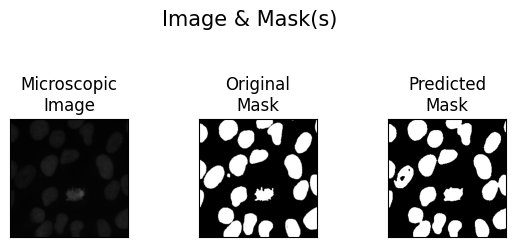

In [66]:
# get the test set images
test_images, test_masks = test_gen.__getitem__(1)
predicted_masks = model.predict(test_images)

predicted_masks = predicted_masks > 0.5

VisualizeImageAndMask(image = test_images[1], mask = test_masks[1], prediction_img = predicted_masks[1])


### Model Evaluation

In [67]:
print("Evaluate on test data")
results = model.evaluate(test_gen)
print("test loss, test acc:", results)

Evaluate on test data
3/3 [==============================] - 2s 509ms/step - loss: 0.0658 - acc: 0.9682
test loss, test acc: [0.06578090041875839, 0.9682382345199585]
